## Visualize Data

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Using Tensorflow version', tf.__version__)

Using Tensorflow version 2.4.0


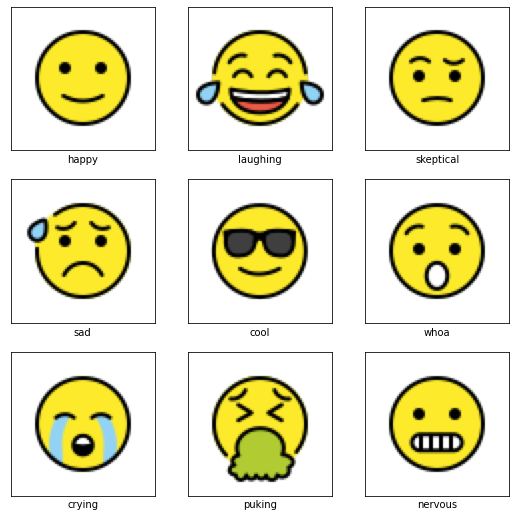

In [2]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Create Examples

In [3]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [4]:
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1B297CF4400>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1B297CF4280>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1B297CF4FD0>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1B297CF4370>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1B297CF43D0>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1B297CF4430>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1B297F1E220>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1B29786BA30>},
 8: {'name': 'nervous',
  'file': '1F62C.pn

In [5]:
def create_example():
    class_id = np.random.randint(0, 9)
    image = np.ones((144, 144, 3)) * 255.
    row = np.random.randint(0, 72)
    col = np.random.randint(0, 72)
    image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
    
    return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144

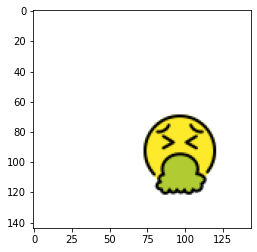

In [6]:
image , class_id, row, col = create_example()
plt.imshow(image)

## Plot Bounding Boxes

In [7]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
    if norm:
        image *= 255.
        image = image.astype('uint8')
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    row, col = gt_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col + 52, row + 52), outline='green', width=3)
    
    if len(pred_coords) == 2:
        row, col = pred_coords
        row *= 144
        col *= 144
        draw.rectangle((col, row, col + 52, row + 52), outline='red', width=3)
    
    return image

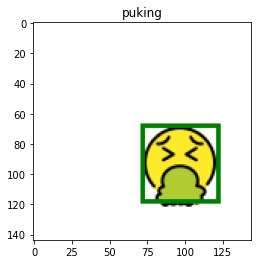

In [8]:
image = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Data Generator

In [9]:
def data_generator(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, 144, 144, 3))
        y_batch = np.zeros((batch_size, 9))
        bbox_batch = np.zeros((batch_size, 2))    # 2: row & column
        
        for i in range(0, batch_size):
            image, class_id, row, col = create_example()
            x_batch[i] = image / 255.
            y_batch[i, class_id] = 1.0
            bbox_batch[i] = np.array([row, col])
        
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}    # First dictionary is for Input, Second dictionary is for Output

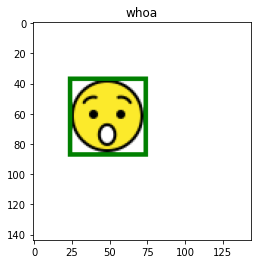

In [10]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Model

In [11]:
input_ = Input(shape=(144, 144, 3), name='image')

x = input_

for i in range(0, 5):
    n_filters = 2 ** (4 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(9, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 142, 142, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 142, 142, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 71, 71, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Custom Metric: IoU

In [12]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)
        
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows * 144, cols * 144
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            
            return x1, y1, x2, y2
        
        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
    
        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)

        i_area = get_area(i_x1, i_y1, i_x2, i_y2)
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

        iou = tf.math.divide(i_area, u_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
        
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

## Compile the Model

In [13]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out': 'accuracy',
        'box_out': IoU(name='iou')
    }
)

## Custom Callback: Model Testing

In [14]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']
    
    pred_y, pred_box = model.predict(x)
    
    pred_coords = pred_box[0]
    gt_coords = box[0]
    pred_class = np.argmax(pred_y[0])
    image = x[0]
    
    gt = emojis[np.argmax(y[0])]['name']
    pred_class_name = emojis[pred_class]['name']
    
    image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
    color = 'green' if gt == pred_class_name else 'red'
    
    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])

In [15]:
def test(model):
    test_datagen = data_generator(1)
    
    plt.figure(figsize=(16, 4))
    
    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
    plt.show()

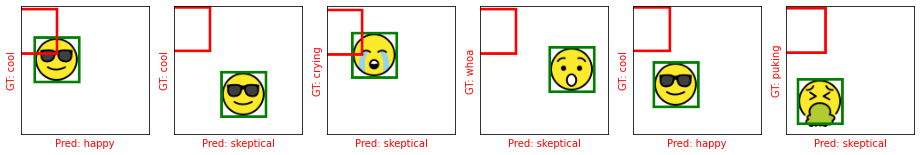

In [16]:
test(model)

In [17]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

## Model Training

Epoch 1/50
500/500 [==============================] - 9s 15ms/step - loss: 2.5690 - class_out_loss: 1.5453 - box_out_loss: 1.0237 - class_out_accuracy: 0.4708 - box_out_iou: 0.1403


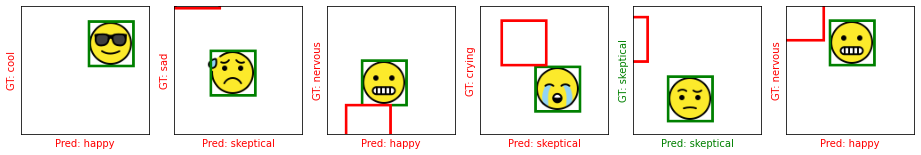

Epoch 2/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0439 - class_out_loss: 0.0125 - box_out_loss: 0.0313 - class_out_accuracy: 0.9995 - box_out_iou: 0.2933


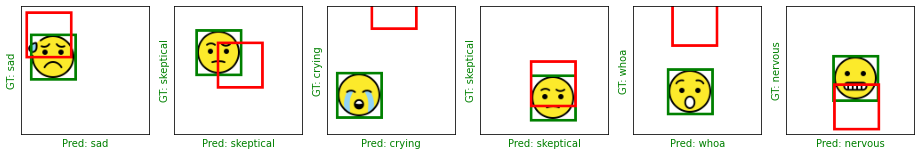

Epoch 3/50
500/500 [==============================] - 7s 15ms/step - loss: 0.0180 - class_out_loss: 0.0035 - box_out_loss: 0.0145 - class_out_accuracy: 0.9999 - box_out_iou: 0.4110


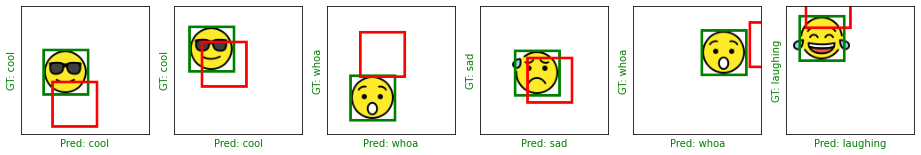

Epoch 4/50
500/500 [==============================] - 7s 15ms/step - loss: 0.0110 - class_out_loss: 0.0022 - box_out_loss: 0.0088 - class_out_accuracy: 1.0000 - box_out_iou: 0.4883


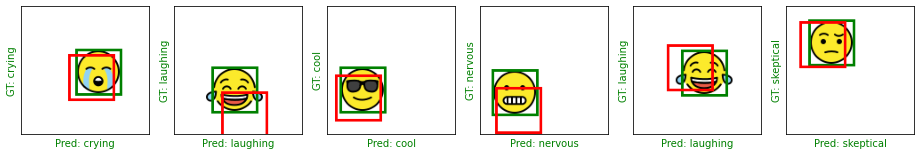

Epoch 5/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0040 - class_out_loss: 8.5649e-04 - box_out_loss: 0.0031 - class_out_accuracy: 1.0000 - box_out_iou: 0.6441


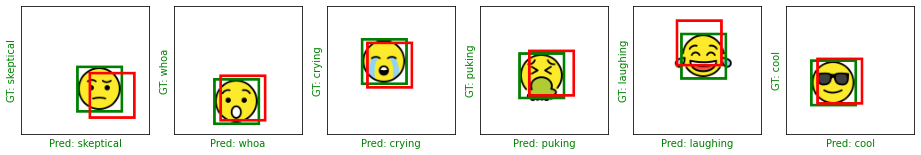

Epoch 6/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0032 - class_out_loss: 6.5071e-04 - box_out_loss: 0.0025 - class_out_accuracy: 1.0000 - box_out_iou: 0.6725


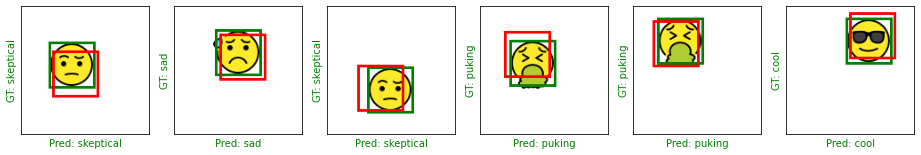

Epoch 7/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0027 - class_out_loss: 4.9537e-04 - box_out_loss: 0.0022 - class_out_accuracy: 1.0000 - box_out_iou: 0.6853


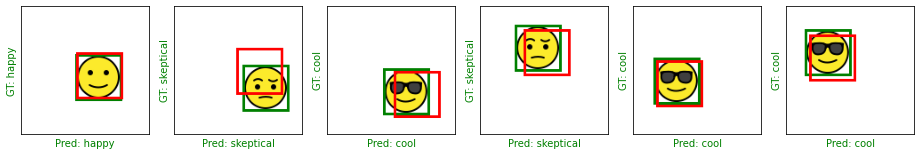

Epoch 8/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0027 - class_out_loss: 4.6622e-04 - box_out_loss: 0.0022 - class_out_accuracy: 1.0000 - box_out_iou: 0.6873


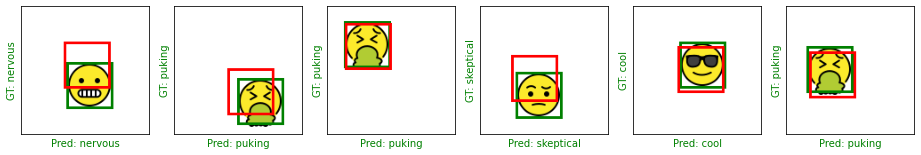

Epoch 9/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0023 - class_out_loss: 3.6465e-04 - box_out_loss: 0.0020 - class_out_accuracy: 1.0000 - box_out_iou: 0.7028


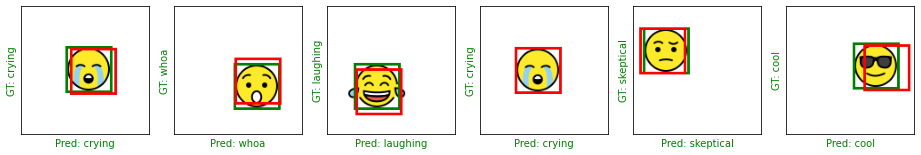

Epoch 10/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0017 - class_out_loss: 2.9811e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7351


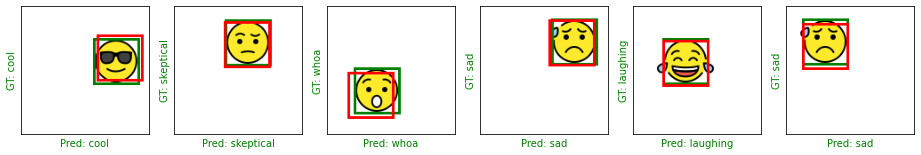

Epoch 11/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0016 - class_out_loss: 2.8351e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7429


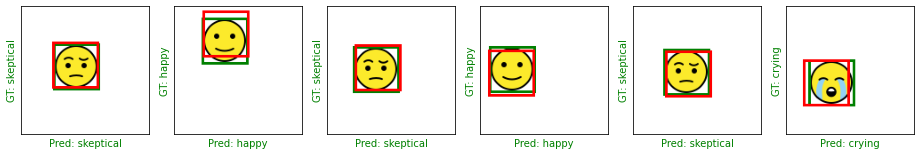

Epoch 12/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0017 - class_out_loss: 3.6781e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7484


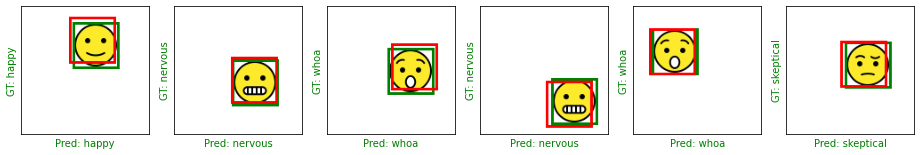

Epoch 13/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0015 - class_out_loss: 2.5790e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7515


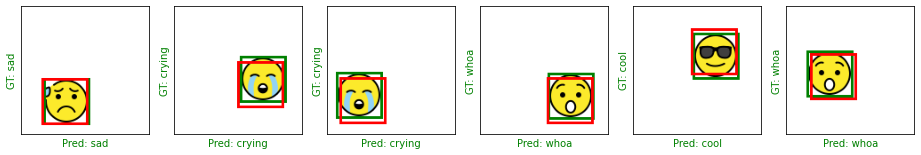

Epoch 14/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0016 - class_out_loss: 2.9208e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7502


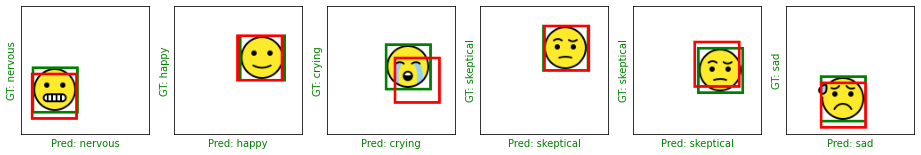

Epoch 15/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0014 - class_out_loss: 2.7513e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7626


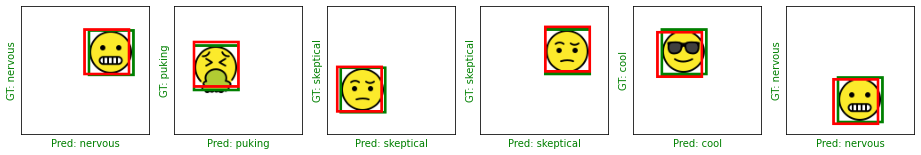

Epoch 16/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0013 - class_out_loss: 2.4892e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7681


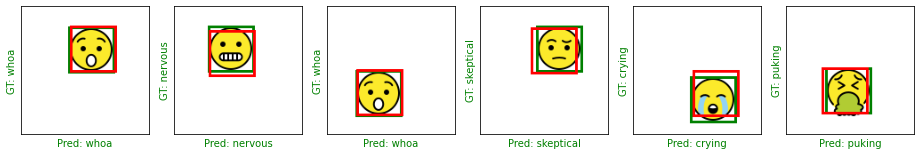

Epoch 17/50
500/500 [==============================] - 8s 15ms/step - loss: 0.0013 - class_out_loss: 2.3438e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7681


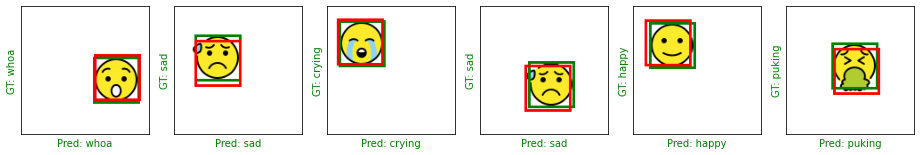

Epoch 18/50
500/500 [==============================] - 8s 15ms/step - loss: 0.0012 - class_out_loss: 2.1279e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7695


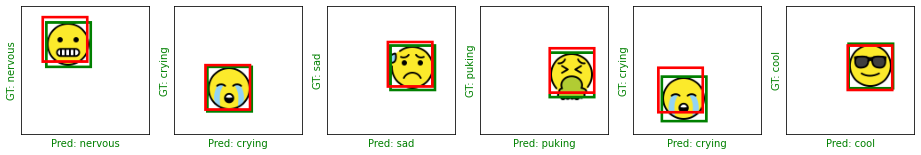

Epoch 19/50
500/500 [==============================] - 8s 15ms/step - loss: 0.0012 - class_out_loss: 2.1540e-04 - box_out_loss: 9.6668e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7763


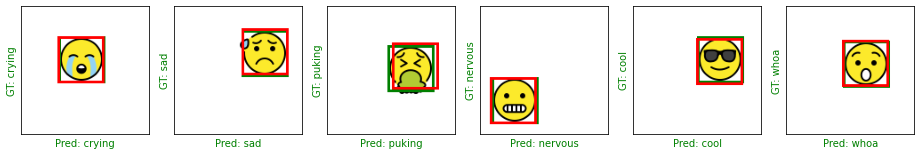

Epoch 20/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0012 - class_out_loss: 2.2770e-04 - box_out_loss: 9.6043e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7760


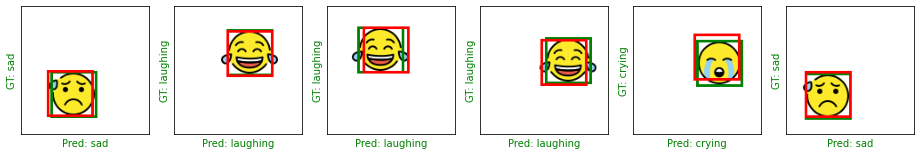

Epoch 21/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0012 - class_out_loss: 2.0857e-04 - box_out_loss: 9.6644e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7764


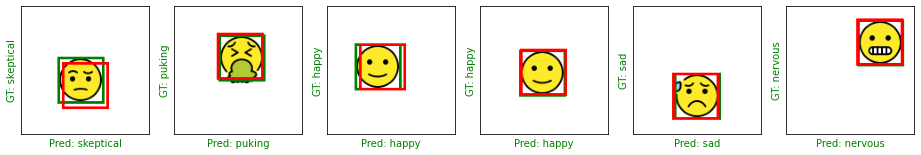

Epoch 22/50
500/500 [==============================] - 9s 17ms/step - loss: 0.0011 - class_out_loss: 1.8694e-04 - box_out_loss: 9.4202e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7774


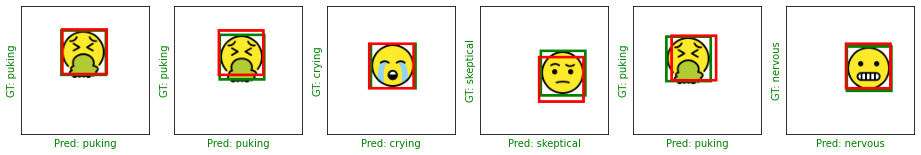

Epoch 23/50
500/500 [==============================] - 8s 15ms/step - loss: 0.0011 - class_out_loss: 2.3000e-04 - box_out_loss: 9.1552e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7800


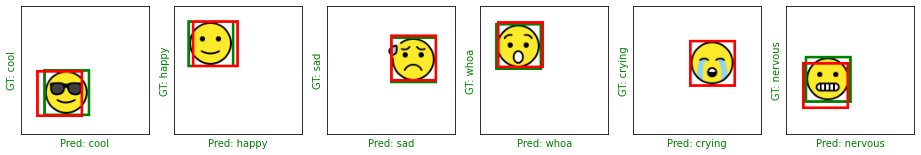

Epoch 24/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 1.7944e-04 - box_out_loss: 9.2906e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7781


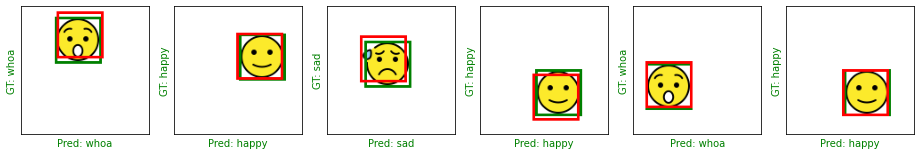

Epoch 25/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 1.8035e-04 - box_out_loss: 9.0481e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7822


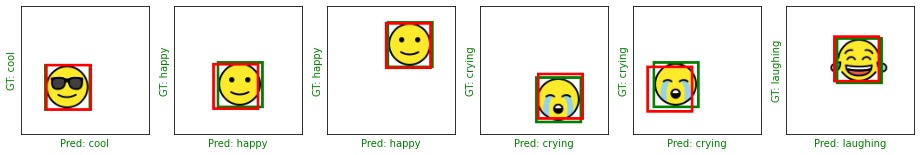

Epoch 26/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0012 - class_out_loss: 2.1613e-04 - box_out_loss: 9.5634e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7782


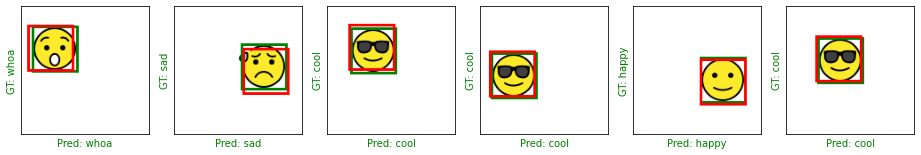

Epoch 27/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 1.6832e-04 - box_out_loss: 8.9633e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7821


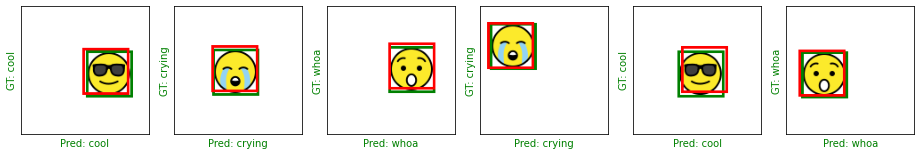

Epoch 28/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 1.8264e-04 - box_out_loss: 9.1031e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7817


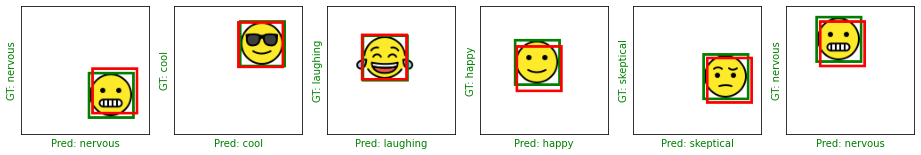

Epoch 29/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 1.9323e-04 - box_out_loss: 8.9119e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7833


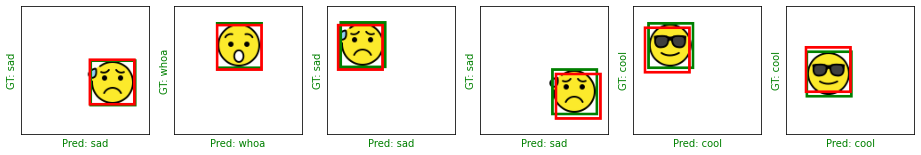

Epoch 30/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 2.0358e-04 - box_out_loss: 8.8890e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7811


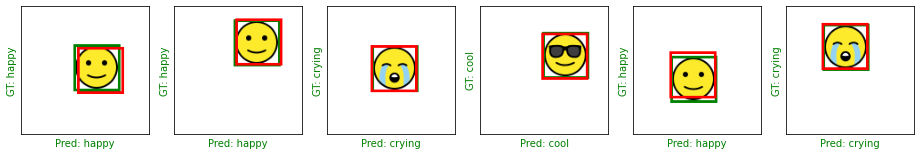

Epoch 31/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 1.9258e-04 - box_out_loss: 9.0927e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7811


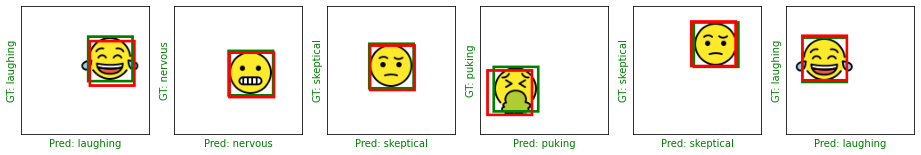

Epoch 32/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 2.2123e-04 - box_out_loss: 9.0695e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7807


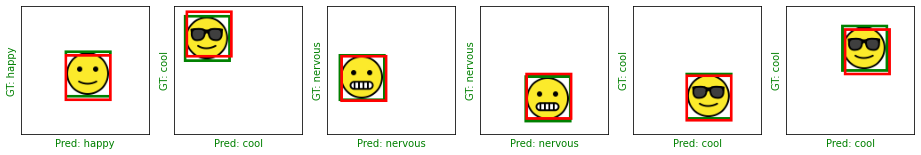

Epoch 33/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 1.8077e-04 - box_out_loss: 8.7498e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7839


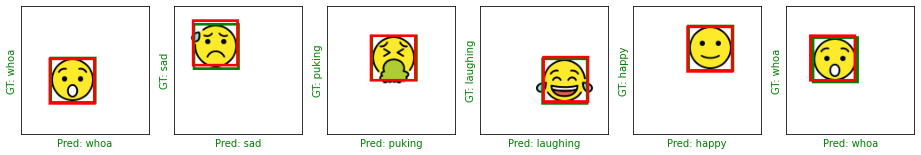

Epoch 34/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 1.8079e-04 - box_out_loss: 8.9705e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7812


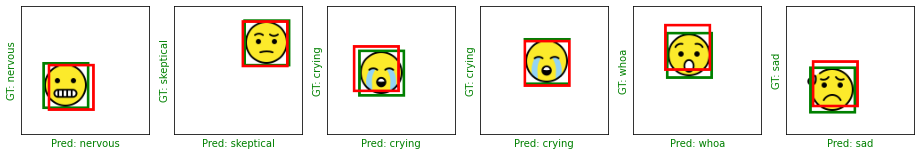

Epoch 35/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0012 - class_out_loss: 2.4757e-04 - box_out_loss: 9.1416e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7802


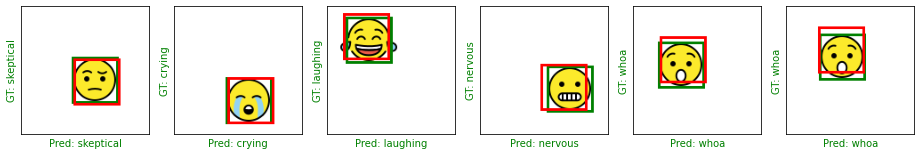

Epoch 36/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 2.2530e-04 - box_out_loss: 8.6603e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7846


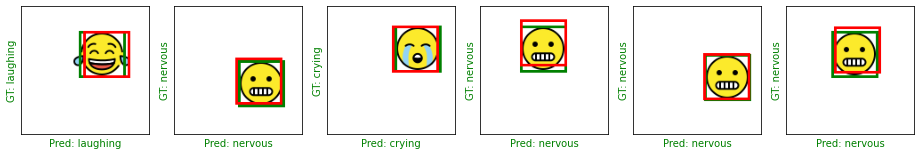

Epoch 37/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 2.0595e-04 - box_out_loss: 9.0016e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7820


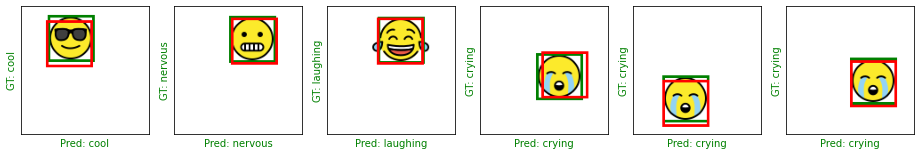

Epoch 38/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 1.7992e-04 - box_out_loss: 8.7635e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7838


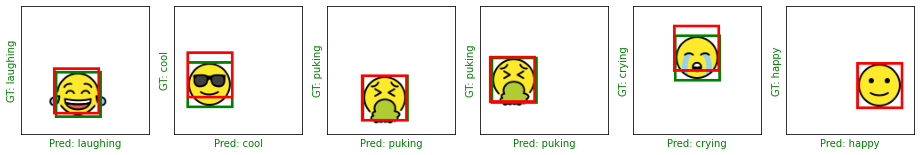

Epoch 39/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0011 - class_out_loss: 1.9792e-04 - box_out_loss: 8.9833e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7825


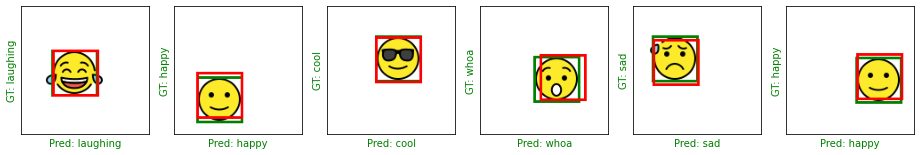

In [18]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 5 == 0:
        lr *= 0.2
    return max(lr, 3e-7)

_ = model.fit(
    data_generator(),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
        ShowTestImages(),
        tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)